## Overview

The code is designed to conduct a causal discovery analysis on time series data using the PCMCI algorithm with Tigramite library in python. The purpose of the analysis is to identify and compare the causal relationships within two datasets, one representing "normal" conditions and the other representing "attack" conditions and carry on an anomaly detection for identify the anomalies in the attack dataset

Here's an overview of how the code works:

1. **Import and Preprocessing:** The code starts by defining a function, `read_preprocess_data`, to import and preprocess data. This function reads a CSV file, selects a subset of the data, removes near-constant and entirely `NaN` columns, and sets the timestamp as the index. We define the function we will use in the code and import the libraries that we need and we also set the Constants variables.

2. **Feature Importance:** In this section we execute an optional feature importance for speeding up the code by selecting before the analysis the variables (sensors) that are more significant

3. **Causal Discovery with PCMCI:** In this section we perform the causal analyis. The `run_pcmci` function runs the PCMCI algorithm on the preprocessed data (NORMAL Dataset) and prints out the time it took to run the process. The `plot_and_extract_links` function creates a visual representation of the causal links discovered by PCMCI and extracts these links into pandas dataframes. We merge the links together and we plot the correlations values in the normal dataset

3. **Anomaly Detection and Alarms logging**: In this section we launch the algorithm on the attack dateset using a rolling windows and we detect the anomalies printing the alarms once we cross a threshold (`CHANGE_LINK_CORRELATION`).

4. **Ground Truth confrontation and score printing:** we confront the code with the ground truth and we print the score for understanding the analyisis

5. **Printing Anomalies and graphs**: in the finaly section we print the detected anomalies and the graphs releated to them for figuring out which sensors where involved in the anomalies and act accordingly by taking appropriate measures

## Import and Preprocessing

In [ ]:
#Import from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tigramite Installation
!pip install tigramite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.2/250.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Libraries Import
import pandas as pd
import numpy as np

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

import datetime
import time
import logging

import warnings
from scipy.stats import ConstantInputWarning

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, accuracy_score
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore', category=ConstantInputWarning)

In [ ]:
# Constants Variables
SUBSET_SIZE = 3000   # Number of rows of normal used to assess normal condition correlations
SUBSET_SIZE_ATTACK = 20000
ALPHA = 0.05          # Significance level to be statistically significant correlation
WINDOW= 350          # Rolling Window of the analysis to perfoming confrontation between normal and attack datasets
NUM_ALARM_THRESHOLD = 1             # Number of alarms to go off to classify as anomaly

In [ ]:
# Function definition section

# Function for reading and preprocessing the normal dataset
def read_preprocess_data_normal(path, SUBSET_SIZE=SUBSET_SIZE):
    try:
        df = pd.read_csv(path, delimiter=";")
        df = df.head(SUBSET_SIZE)
        df = df.loc[:, (df != df.iloc[0]).any()] # Remove near constant columns
        df = df.dropna(axis=1, how='all') # Drop columns that are entirely NaN
        df['Timestamp'] = df[' Timestamp'].str.strip()
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %I:%M:%S %p")
        df.set_index('Timestamp', inplace=True)
        columns_to_drop = [' Timestamp', 'Normal/Attack']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
        return df

    except FileNotFoundError:
        print("File not found")
        return None

# Function for reading and preprocessing the attack dataset
def read_preprocess_data(path, SUBSET_SIZE=SUBSET_SIZE_ATTACK):
    try:
        df = pd.read_csv(path, delimiter=";")
        df = df.head(SUBSET_SIZE)
        #df = df.loc[:, (df != df.iloc[0]).any()] # Remove near constant columns
        #df = df.dropna(axis=1, how='all') # Drop columns that are entirely NaN
        df[' Timestamp'] = df[' Timestamp'].str.strip()
        df[' Timestamp'] = pd.to_datetime(df[' Timestamp'], format="%d/%m/%Y %I:%M:%S %p")
        #df.set_index('Timestamp', inplace=True)
        columns_to_drop = [' Timestamp', 'Normal/Attack']
        df1=df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=False)
        #columns_to_drop = [ 'Normal/Attack']
       # df2=df.drop(columns=[col for col in df.columns if col not in columns_to_drop])
        df2 = df["Normal/Attack"]
        return df1,df2

    except FileNotFoundError:
        print("File not found")
        return None


# Executes the PCMCI causal discovery algorithm in the normal dataset
def run_pcmci(data):
    start_time = time.time()
    pcmci = PCMCI(dataframe=data, cond_ind_test=ParCorr())
    results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
    end_time = time.time()
    print("Time taken ",end_time - start_time)

    return results

# Executes the PCMCI causal discovery algorithm in the attack dataset on a rolling window
def run_pcmci_for_all_subsets(all_subsets):
    pcmci_results = []
    for subset in all_subsets:
        new_data = pp.DataFrame(subset.values)
        results_new = run_pcmci(new_data)
        pcmci_results.append(results_new)
    return pcmci_results

# Tigramite function for plotting and extracting the link in the time series analysis
def plot_and_extract_links(results, df, graph_name_prefix, plot_graphs=True):
    # Define the significance level for the p-values
    alpha_level = ALPHA

    # Extract the matrices of test statistic values and p-values from the results
    val_matrix = results['val_matrix'].copy()
    p_matrix = results['p_matrix'].copy()

    # Create a boolean link matrix where links are significant at the given alpha level
    link_matrix = p_matrix <= alpha_level

    # Copy the link matrix for contemporaneous and lagged graphs
    contemp_graph = link_matrix.copy()
    lagged_graph = link_matrix.copy()

    # For the contemporaneous graph, set all non-zero lags to False
    contemp_graph[:, :, 1:] = False
    lagged_graph[:, :, 0] = False

    # Extract the significant contemporaneous and lagged links from the graphs
    var_names = list(df.columns)

    # Plot the contemporaneous and lagged graphs using tigramite's plot_graph function
    # Also save the plot as a .png file
    if plot_graphs:
      tp.plot_graph(
          val_matrix=val_matrix * contemp_graph,
          graph=contemp_graph,
          var_names=var_names,
          save_name=f'{graph_name_prefix}_contemp_graph.png',
          figsize=(10, 10),
          node_size=0.1,
          node_label_size=8,
          link_label_fontsize=6
      )

      tp.plot_graph(
          val_matrix=val_matrix * lagged_graph,
          graph=lagged_graph,
          var_names=var_names,
          save_name=f'{graph_name_prefix}_lagged_graph.png',
          figsize=(10, 10),
          node_size=0.1,
          node_label_size=8,
          link_label_fontsize=6
      )

    contemp_links = np.where(contemp_graph)
    lagged_links = np.where(lagged_graph)

    # Create DataFrames for the significant links, with columns for variables involved, lag and the test statistic value
    contemp_df = pd.DataFrame(
        {'Variable1': [var_names[i] for i in contemp_links[0]],
         'Variable2': [var_names[i] for i in contemp_links[1]],
         'Lag': contemp_links[2],
         'Value': val_matrix[contemp_links]})

    lagged_df = pd.DataFrame(
        {'Variable1': [var_names[i] for i in lagged_links[0]],
         'Variable2': [var_names[i] for i in lagged_links[1]],
         'Lag': lagged_links[2],
         'Value': val_matrix[lagged_links]})


    # Sort the significant links in the DataFrames by the absolute value of the test statistic
    contemp_df['abs_value'] = contemp_df['Value'].abs()
    contemp_df = contemp_df.sort_values('abs_value', ascending=False).drop(columns='abs_value')

    lagged_df['abs_value'] = lagged_df['Value'].abs()
    lagged_df = lagged_df.sort_values('abs_value', ascending=False).drop(columns='abs_value')

    return contemp_df, lagged_df

## Causal Analysis with PCMCI Algorithm

In [ ]:
# Read in data, put here the source of the dataset
normal_df = read_preprocess_data_normal("/content/drive/My Drive/Anomaly Detection Results 2/swat_dset/swat_csv/SWaT_Dataset_Normal_v1.csv")
#attack_df = read_preprocess_data("/content/drive/My Drive/Anomaly Detection Results 2/swat_dset/swat_csv/SWaT_Dataset_Attack_v0.csv")

#Dividing the datasets in windows for splitting the analysis
normal_subsets = [normal_df.iloc[i:i+WINDOW] for i in range(0, len(normal_df), WINDOW)]
#attack_subsets = [attack_df.iloc[i:i+WINDOW] for i in range(0, len(attack_df), WINDOW)]

# Assigning labels: 0 for normal and 1 for attack
normal_labels = [0] * len(normal_subsets)
#attack_labels = [1] * len(attack_subsets)


Time taken  234.45111632347107


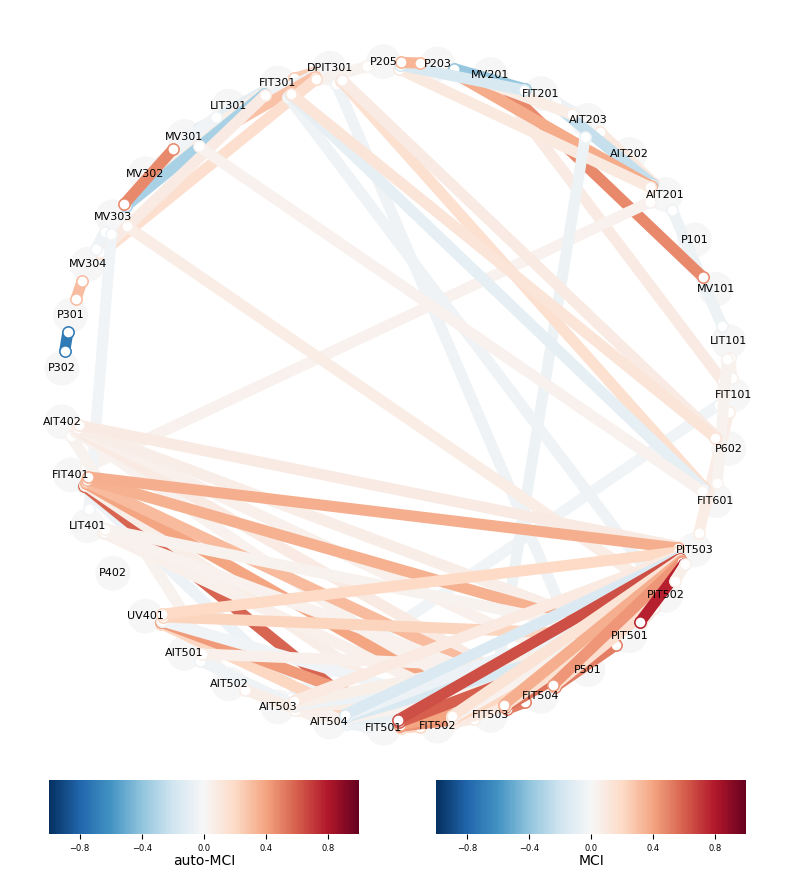

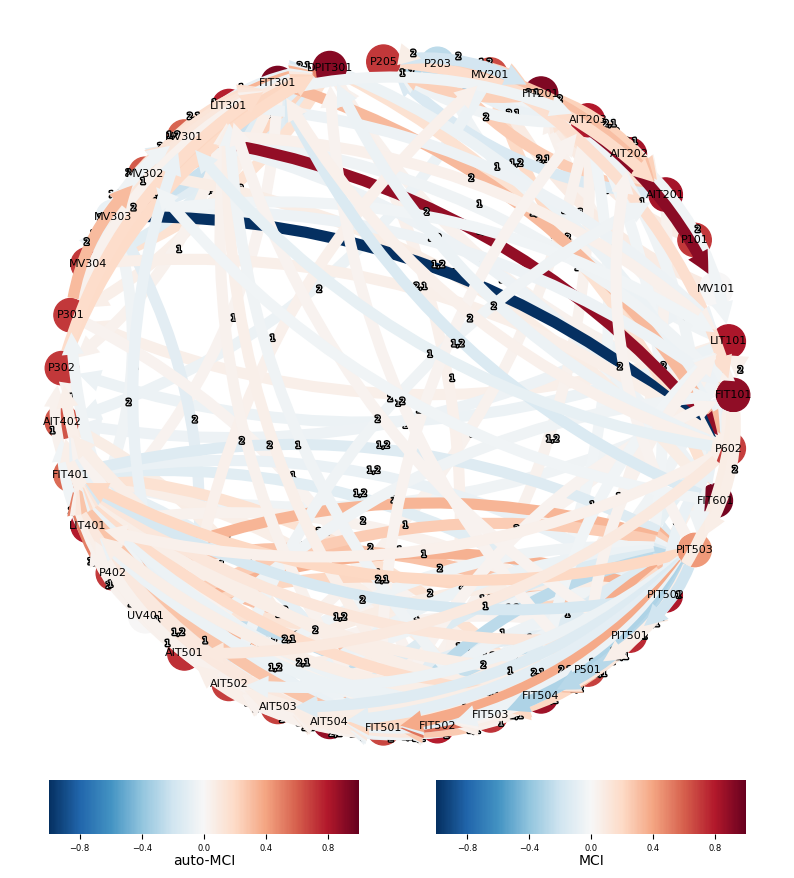

In [ ]:
# Run PCMCI on the normal dataset and select the threshold
normal_data = pp.DataFrame(normal_df.values)
results_normal = run_pcmci(normal_data)
contemp_df_normal, lagged_df_normal = plot_and_extract_links(results_normal, normal_df, 'normal')

In [ ]:
# Calculate the threshold based on the top % links
threshold_percentile = 0.3            #CHANGE THIS TO SELECT THE TOP % CAUSAL LINKS OF THE NORMAL DATASET TO BE CONSIDERED FOR THE ANOMALY DETECTION IN ATTACK DATASET
threshold_value = contemp_df_normal['Value'].abs().quantile(1 - threshold_percentile)
threshold_value_atk = lagged_df_normal['Value'].abs().quantile(1 - threshold_percentile)

# Filter the most important links based on the threshold
normal_df_filtered = contemp_df_normal[contemp_df_normal['Value'].abs() > threshold_value]
normal_df_filtered_lag = lagged_df_normal[lagged_df_normal['Value'].abs() > threshold_value_atk]
normal_df_links = pd.concat([normal_df_filtered, normal_df_filtered_lag], ignore_index=True)

In [ ]:
print(normal_df_links)

    Variable1 Variable2  Lag     Value
0      PIT501    PIT503    0  0.774302
1      PIT503    PIT501    0  0.774302
2        P301      P302    0 -0.708672
3        P302      P301    0 -0.708672
4      FIT501    PIT503    0  0.641310
..        ...       ...  ...       ...
177     MV302    FIT301    2  0.158808
178    FIT201    AIT201    1 -0.158187
179    AIT201      P205    1 -0.153960
180    FIT401    FIT504    2  0.152042
181   DPIT301    FIT601    1  0.151636

[182 rows x 4 columns]


## Anomaly Detection and Alarms logging

In [ ]:
import logging

# Create or get the logger
logger = logging.getLogger(__name__)

# set log level
logger.setLevel(logging.INFO)

# define file handler and set formatter
file_handler = logging.FileHandler('alarm_logs.txt')
formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

'\nattack_subset_timestamps_array = [\n    \'2015-12-28 10:29:03\', \'2015-12-28 10:29:04\', \'2015-12-28 10:29:05\', \'2015-12-28 10:29:06\',\n    \'2015-12-28 10:29:07\', \'2015-12-28 10:29:08\', \'2015-12-28 10:29:09\', \'2015-12-28 10:29:11\',\n    \'2015-12-28 10:29:12\', \'2015-12-28 10:29:13\', \'2015-12-28 10:29:14\', \'2015-12-28 10:29:15\',\n    \'2015-12-28 10:29:16\', \'2015-12-28 10:29:17\', \'2015-12-28 10:29:18\', \'2015-12-28 10:29:19\',\n    \'2015-12-28 10:29:20\', \'2015-12-28 10:29:21\', \'2015-12-28 10:29:22\', \'2015-12-28 10:29:23\',\n]\n# Create a DataFrame with the "Timestamp" column\nattack_subset_timestamps = pd.DataFrame({\'Timestamp\': attack_subset_timestamps_array})\n\nprint(attack_subset_timestamps )\n'

In [ ]:
# Anomaly Detection function
def detect_anomalies(subset, normal_df_links, CHANGE_LINK_CORRELATION, NUM_ALARM_THRESHOLD, detect_anomalies):
    new_data = pp.DataFrame(subset.values)
    results_new = run_pcmci(new_data)

    contemp_df_new, lagged_df_new = plot_and_extract_links(results_new, subset, 'new', plot_graphs=False)
    new_df_combined = pd.concat([contemp_df_new, lagged_df_new], ignore_index=True)
    print(new_df_combined)

    merged_new_df = pd.merge(normal_df_links, new_df_combined, how='left',
                             on=['Variable1', 'Variable2', 'Lag'], suffixes=('_normal', '_new'))
    merged_new_df['Value_new'] = merged_new_df['Value_new'].fillna(0)
    merged_new_df['Value_diff'] = (merged_new_df['Value_new'] - merged_new_df['Value_normal']) / merged_new_df['Value_normal']
    anomalies = merged_new_df[(merged_new_df['Value_diff'].abs() > CHANGE_LINK_CORRELATION) & (merged_new_df['Value_new'] > 0)]

    if not anomalies.empty and detect_anomalies == 0:
        anomaly_variables = np.unique(np.concatenate((anomalies['Variable1'].unique(), anomalies['Variable2'].unique())))

        for index, row in anomalies.iterrows():
            alarm_msg = f"Alarm at time {subset.index[-1]}! Anomaly detected in link ({row['Variable1']}, {row['Variable2']}, {row['Lag']}). Change in correlation: {row['Value_diff']}"
            print(alarm_msg)
            logger.info(alarm_msg)

        alpha_level = 0.05
        link_matrix = results_new['p_matrix'] <= alpha_level
        anomaly_graph = np.zeros_like(link_matrix, dtype=bool)
        for index, row in anomalies.iterrows():
            try:
                i, j, tau = subset.columns.str.strip().tolist().index(row['Variable1'].strip()), subset.columns.str.strip().tolist().index(row['Variable2'].strip()), row['Lag']
                anomaly_graph[i, j, tau] = True
            except ValueError:
                continue

        anomaly_graph = np.logical_and(link_matrix, anomaly_graph)
        tp.plot_graph(
            val_matrix=results_new['val_matrix'] * anomaly_graph,
            graph=anomaly_graph,
            var_names=subset.columns.tolist(),
            save_name=f'anomalies_graph_{subset.index[-1]}.png',
            figsize=(10, 10),
            node_size=0.1,
            node_label_size=8,
            link_label_fontsize=6
        )

    if len(anomalies) >= NUM_ALARM_THRESHOLD:
        return 1
    else:
        return 0


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in log")
warnings.filterwarnings("ignore", category=UserWarning, message="An input array is nearly constant; the computed correlation coefficient may be inaccurate.")

def detect_anomalies_2(subset, normal_df_links, CHANGE_LINK_CORRELATION, NUM_ALARM_THRESHOLD, detect_anomalies):
    new_data = pp.DataFrame(subset.values)
    results_new = run_pcmci(new_data)
    contemp_df_new, lagged_df_new = plot_and_extract_links(results_new, subset, 'new', plot_graphs=False)
    new_df_combined = pd.concat([contemp_df_new, lagged_df_new], ignore_index=True)


     # Find common elements between normal_df_links and contemp_df_new based on 'Variable1' and 'Variable2'
    common_elements = normal_df_links.merge(contemp_df_new, on=['Variable1', 'Variable2'])
    new_df = common_elements[['Variable1', 'Variable2', 'Lag_y', 'Value_y']]

    # Rename the columns
    new_df.columns = ['Variable1', 'Variable2', 'Lag', 'Value']
    #print(new_df)

    merged_new_df = pd.merge(normal_df_links, new_df, how='left',
                             on=['Variable1', 'Variable2', 'Lag'], suffixes=('_normal', '_new'))
    merged_new_df['Value_new'] = merged_new_df['Value_new'].fillna(0)
    merged_new_df['Value_diff'] = (merged_new_df['Value_new'] - merged_new_df['Value_normal']) / merged_new_df['Value_normal']
    anomalies = merged_new_df[(merged_new_df['Value_diff'].abs() > CHANGE_LINK_CORRELATION) & (merged_new_df['Value_new'] > 0)]

    for index, row in anomalies.iterrows():
          alarm_msg = f"Alarm at time {subset.index[-1]}! Anomaly detected in link ({row['Variable1']}, {row['Variable2']}, {row['Lag']}). Change in correlation: {row['Value_diff']}"
          print(alarm_msg)
          logger.info(alarm_msg)

    if len(anomalies) >= NUM_ALARM_THRESHOLD:
        return len(anomalies)
    else:
        return 0


## Ground Truth confrontation and score printing

In [ ]:
attack_df, ground_truth_df= read_preprocess_data("/content/drive/My Drive/Anomaly Detection Results 2/swat_dset/swat_csv/SWaT_Dataset_Attack_v0.csv",SUBSET_SIZE_ATTACK)
attack_subsets = [attack_df.iloc[i:i+WINDOW] for i in range(0, len(attack_df), WINDOW)]
gt_subsets = [ground_truth_df.iloc[i:i+WINDOW] for i in range(0, len(ground_truth_df), WINDOW)]

CHANGE_LINK_CORRELATION = 0.75  # Change in sensor to be classified as an alarm

# Anomaly Detection - Part 2
threshold_for_detection = CHANGE_LINK_CORRELATION
predictions = []
gt = []

for idx, attack_subsets in enumerate(attack_subsets):
  prediction = detect_anomalies_2(attack_subsets, normal_df_links, threshold_for_detection, NUM_ALARM_THRESHOLD, 0)
  predictions.append(prediction)
  gt.append(np.any(np.array(gt_subsets[idx])=="Attack"))


[9, 0, 13, 8, 5, 4, 5, 10, 4, 0, 5, 0, 5, 4, 9, 0, 9, 5, 5, 3, 8, 9, 0, 9, 0, 0, 0, 10, 0, 4, 5, 8, 10, 0, 3, 5, 4, 5, 10, 0, 0, 5, 5, 4, 0, 4, 0, 4, 0, 5, 5, 4, 3, 3, 8, 7, 4, 0]
[False, False, False, False, False, True, True, True, True, True, True, False, False, False, True, True, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False]


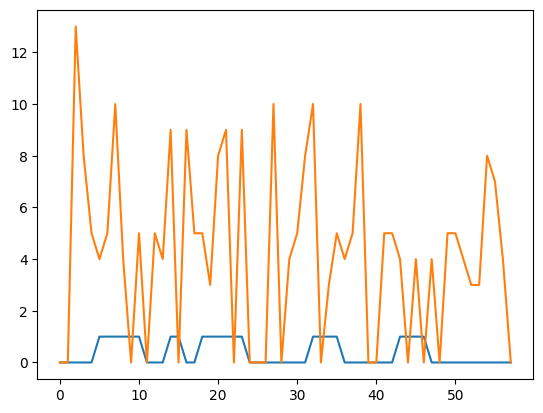

In [ ]:
#Plot Testing
print(predictions)
print(gt)

predictions[0] = 0

plt.plot(gt)
plt.plot(predictions)
plt.show()

In [ ]:
# Normalize the predictions to the [0, 1] range using Min-Max scaling
min_value = min(predictions)
max_value = max(predictions)

normalized_predictions = [(x - min_value) / (max_value - min_value) for x in predictions]

# Find the indices where predictions change or are not 0
change_indices = [i for i in range(1, len(normalized_predictions)) if normalized_predictions[i] != normalized_predictions[i - 1] and normalized_predictions[i] != 0]

# Plot the graph
plt.plot(gt)
plt.plot(normalized_predictions)

# Plot the numbers at the change points
for i in change_indices:
    if normalized_predictions[i] != 0:
        plt.text(i, normalized_predictions[i], str(predictions[i]), ha='center', va='bottom', fontsize=8)

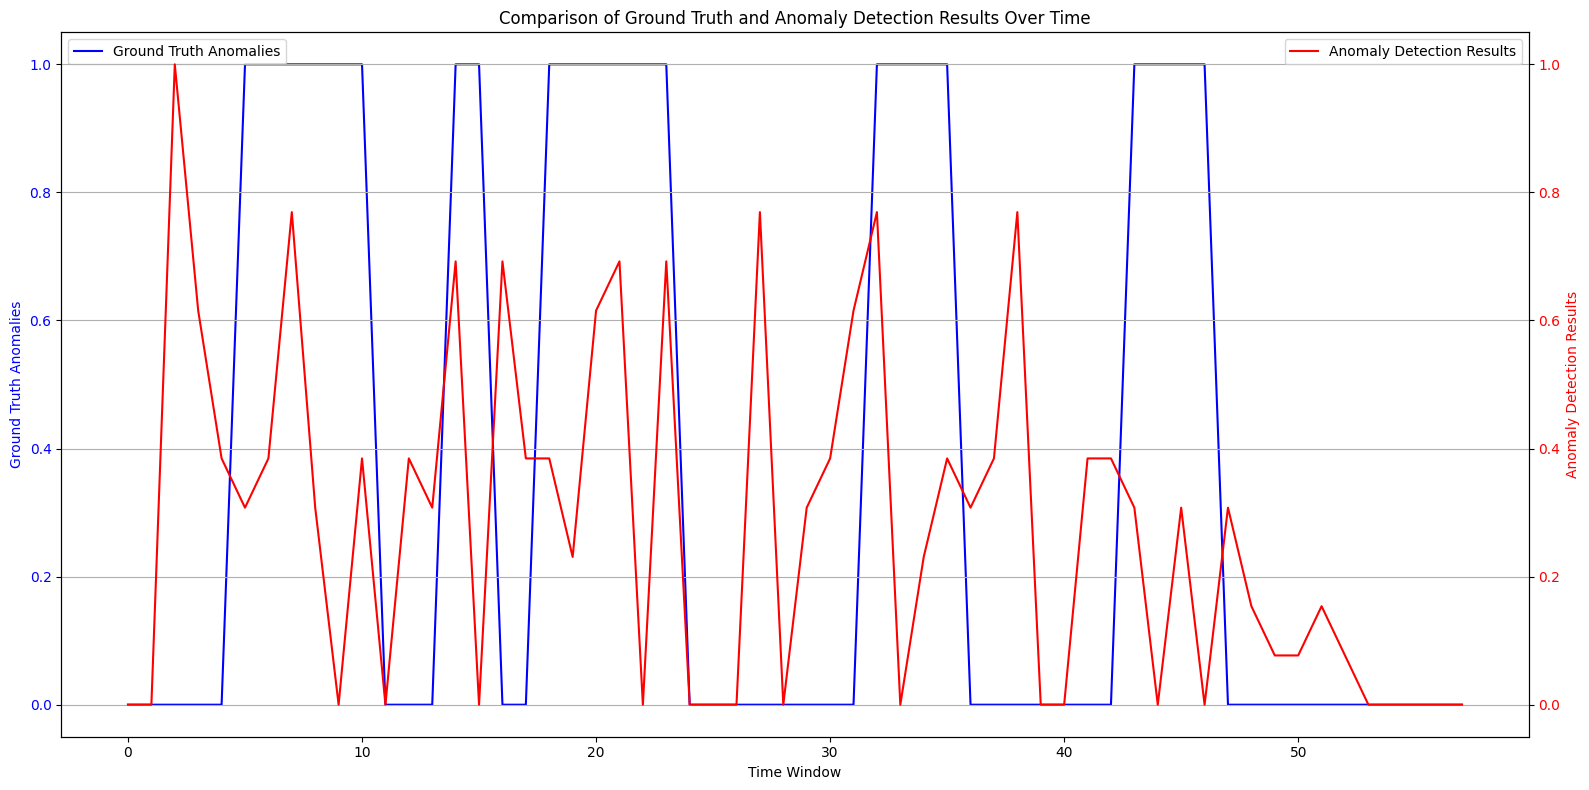

In [ ]:
#Plotting Ground truth and anomaly detection over time

ground_truth_anomalies = gt  # Sample ground truth anomalies (0 for normal, 1 for anomaly)
anomaly_detection_results = normalized_predictions   # Sample detection results (e.g., anomaly scores)
timestamps = list(range(len(normalized_predictions)))

# Convert timestamps to datetime objects
#timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Format timestamps to show only hours, minutes, and seconds
##formatted_timestamps = [ts.strftime('%H:%M:%S') for ts in timestamps]

# Create a DataFrame
graph_data = {
    'Time Window': timestamps,
    'GroundTruthAnomalies': ground_truth_anomalies,
    'DetectionResults': anomaly_detection_results
}
df = pd.DataFrame(graph_data)

# Plotting the graph with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plotting ground truth anomalies (blue line)
ax1.plot(df['Time Window'], df['GroundTruthAnomalies'], color='blue', label='Ground Truth Anomalies')
ax1.set_xlabel('Time Window')
ax1.set_ylabel('Ground Truth Anomalies', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a second y-axis
ax2 = ax1.twinx()

# Plotting anomaly detection results (red line)
ax2.plot(df['Time Window'], df['DetectionResults'], color='red', label='Anomaly Detection Results')
ax2.set_ylabel('Anomaly Detection Results', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding legends
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Show the plot
plt.title('Comparison of Ground Truth and Anomaly Detection Results Over Time')
plt.grid()
plt.tight_layout()  # Ensures labels fit within the plot area
plt.show()

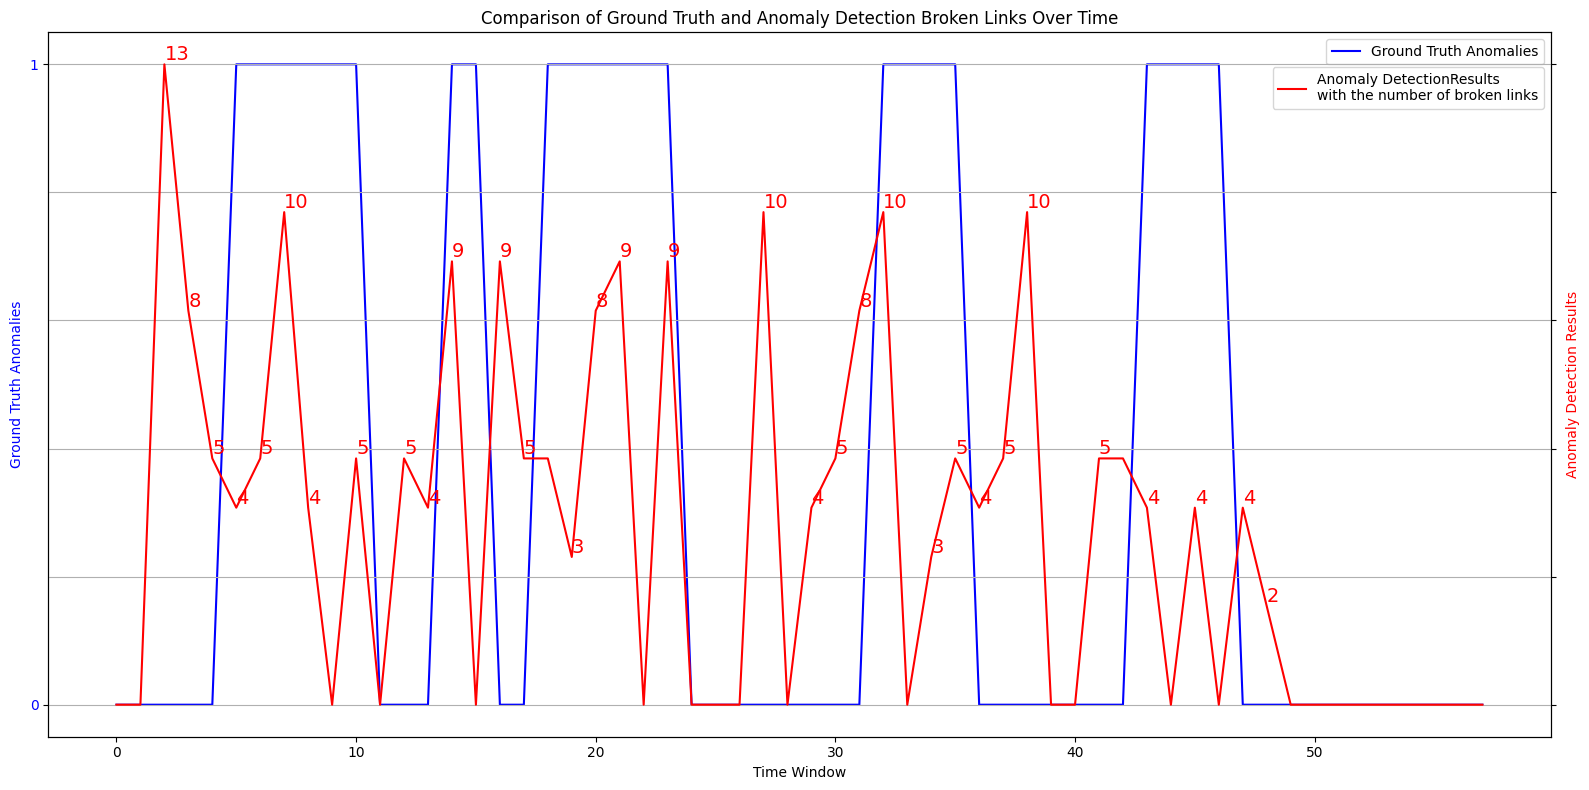

In [ ]:
#Plotting Ground truth and anomaly detection over time with broken links

# Sample data (replace with your actual data)
ground_truth_anomalies = gt  # Sample ground truth anomalies (0 for normal, 1 for anomaly)
anomaly_detection_results = normalized_predictions  # Sample detection results (e.g., anomaly scores)

# Find the indices where predictions change or are not 0
change_indices = [i for i in range(1, len(anomaly_detection_results)) if
                  anomaly_detection_results[i] != anomaly_detection_results[i - 1] and anomaly_detection_results[i] != 0]

# Create a DataFrame
graph_data = {
    'Time Window': list(range(len(anomaly_detection_results))),
    'GroundTruthAnomalies': ground_truth_anomalies,
    'DetectionResults': anomaly_detection_results
}
df = pd.DataFrame(graph_data)

# Plotting the graph with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plotting ground truth anomalies (blue line)
ax1.plot(df['Time Window'], df['GroundTruthAnomalies'], color='blue', label='Ground Truth Anomalies')
ax1.set_xlabel('Time Window')
ax1.set_ylabel('Ground Truth Anomalies', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a second y-axis
ax2 = ax1.twinx()

# Plotting anomaly detection results (red line)
ax2.plot(df['Time Window'], df['DetectionResults'], color='red', label='Anomaly DetectionResults \nwith the number of broken links')
ax2.set_ylabel('Anomaly Detection Results', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Removing tick labels on the right side
ax2.set_yticklabels([])  # Remove tick labels on the right

# Setting custom tick labels on the left side
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['0', '1'], color='blue')  # Custom tick labels in blue

# Adding legends in the upper right corner, stacked on top of each other
ax1_legend = ax1.legend(loc='upper right', fontsize=10)
ax2_legend = ax2.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1, 0.96))  # Adjust the y-coordinate to stack them

# Plot the graph
plt.title('Comparison of Ground Truth and Anomaly Detection Results with broken links over time')
plt.grid()

# Print the values from predictions at the change points (2 times bigger, red, and without decimal digits)
for i in change_indices:
    if anomaly_detection_results[i] != 0:
        plt.text(i, anomaly_detection_results[i], f'{predictions[i]:.0f}', ha='left', va='bottom', fontsize=14, color='red')

plt.tight_layout()  # Ensures labels fit within the plot area
plt.show()
